In [31]:
import cv2
import numpy as np
import pandas as pd
import glob
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [32]:
def showkeypoints(image,key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')

In [33]:
from torch.utils.data import Dataset, DataLoader
class FacialDetector(Dataset):
    def __init__(self, csv_file, root_dir,transform=None):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.key_pts_frame)
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx,0])
        image = mpimg.imread(image_name)
        if(image.shape[2]==4):
            image = image[:,:,0:3]
        key_pts = self.key_pts_frame.iloc[idx,1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1,2)
        sample = {'image':image,'keypoints':key_pts}
        if self.transform:
            sample = self.transform
            
        return sample

In [34]:
dataset = FacialDetector('data/training_frames_keypoints.csv','data/training/')
print('length of dataset:',len(dataset))

length of dataset: 3462


0 (204, 144, 3) (68, 2)
1 (164, 148, 3) (68, 2)
2 (210, 180, 3) (68, 2)
3 (177, 207, 3) (68, 2)


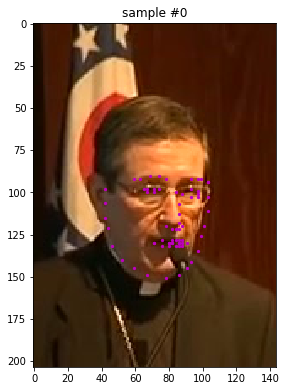

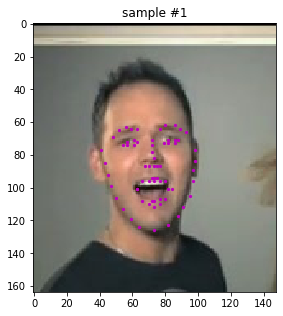

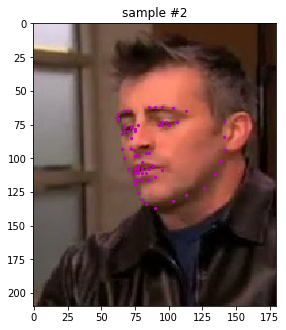

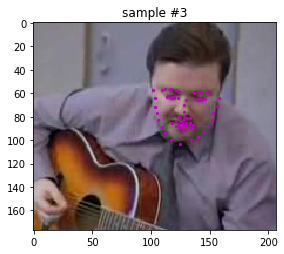

In [35]:
number_to_display = 4
for i in range(number_to_display):
    fig = plt.figure(figsize=(20,10))
    rand_i = np.random.randint(0, len(dataset))
    sample = dataset[rand_i]
    print(i, sample['image'].shape, sample['keypoints'].shape)
    ax = plt.subplot(1, number_to_display,i+1)
    ax.set_title("sample #{}".format(i))
    showkeypoints(sample['image'],sample['keypoints'])

In [36]:
import torch
from torchvision import utils, transforms

class Normalize(object):
     def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}

In [37]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}

In [38]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


In [39]:
class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample['image'],sample['keypoints']
        if(len(image.shape)==2):
            image = image.reshape[image.shape[0],image.shape[1],1]
        image = image.transponse((2,0,1))
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

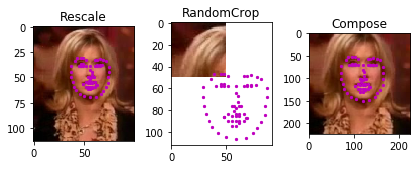

In [40]:
rescale = Rescale(100)
crop = RandomCrop(50)
compose = transforms.Compose([Rescale(250),RandomCrop(224)])

test_num = 500
sample = dataset[test_num]


fig = plt.figure()
for i , tx in enumerate([rescale,crop,compose]):
    transformed_sample = tx(sample)
    ax = plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    showkeypoints(transformed_sample['image'],transformed_sample['keypoints'])
plt.show()

In [41]:
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from models import Net
net  = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2,

In [43]:
from torchvision import utils, transforms
from torch.utils.data import DataLoader, Dataset
from data_load import FacialDetector
from data_load import Normalize, Rescale, RandomCrop, ToTensor
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
assert(data_transform is not None), 'Define a data_transform'

In [44]:
transformed_dataset = FacialDetector(csv_file='data/training_frames_keypoints.csv',root_dir='data/training',transform=data_transform)
print("Length of Data: ",len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Length of Data:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [45]:
batch_size = 10
train_loader = DataLoader(transformed_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
test_dataset = FacialDetector(csv_file='data/test_frames_keypoints.csv',root_dir='data/test',transform = data_transform)
batch_size = 10
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers = 4)

In [46]:
def net_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0],68,-1)
        if i==0:
            return images, output_pts, key_pts

In [47]:
test_images, test_outputs, get_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(get_pts.size())

C:\Users\khurmi\anaconda3\envs\khurmi\lib\site-packages\torch\nn\functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [48]:
def show_all_keypoints(image,predicted_pts,get_pts=None):
    plt.imshow(image,cmap='gray')
    plt.scatter(predicted_pts[:,0],predicted_pts[:,1],s=2,marker='.',c='m')
    if get_pts is not None:
        plt.scatter(get_pts[:,0],get_pts[:,1],s=20,marker='.',c='m')

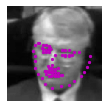

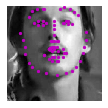

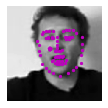

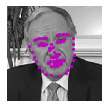

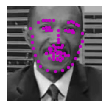

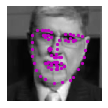

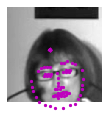

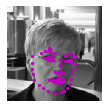

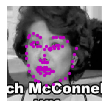

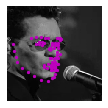

In [49]:
def visualize_output(test_images,test_outputs,get_pts=None,batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1,batch_size,i+1)
        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(image,(1,2,0))
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts*50.0 + 100
        ground_truth_pts = None
        if get_pts is not None:
            ground_truth_pts = get_pts[i]
            ground_truth_pts  = ground_truth_pts * 50.0 + 100
        show_all_keypoints(np.squeeze(image),predicted_key_pts,ground_truth_pts)
        plt.axis('off')
    plt.show()
    
visualize_output(test_images, test_outputs,get_pts)

In [50]:
import torch.optim as optim
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(),lr = 0.001)

In [51]:
def train_net(n_epochs):
    net.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0),-1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            output_pts  = net(images)
            loss  =criterion(output_pts,key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_i % 10 == 9:
                print('Epoch:{},Batch :{},Avg_loss :{}'.format(epoch+1,batch_i+1,running_loss/1000))
                running_loss = 0.0
    print("Finished Training")
            

In [52]:
n_epochs = 1
train_net(n_epochs)

Epoch:1,Batch :10,Avg_loss :0.001813741683959961
Epoch:1,Batch :20,Avg_loss :0.0011742850095033646
Epoch:1,Batch :30,Avg_loss :0.0011744593605399131
Epoch:1,Batch :40,Avg_loss :0.001012481652200222
Epoch:1,Batch :50,Avg_loss :0.0011813948825001716
Epoch:1,Batch :60,Avg_loss :0.0009795580133795739
Epoch:1,Batch :70,Avg_loss :0.0010168428868055344
Epoch:1,Batch :80,Avg_loss :0.001202467255294323
Epoch:1,Batch :90,Avg_loss :0.0011113272570073606
Epoch:1,Batch :100,Avg_loss :0.0010366851314902305
Epoch:1,Batch :110,Avg_loss :0.0011696048937737942
Epoch:1,Batch :120,Avg_loss :0.0009324647597968578
Epoch:1,Batch :130,Avg_loss :0.0011679610162973403
Epoch:1,Batch :140,Avg_loss :0.0009227813296020031
Epoch:1,Batch :150,Avg_loss :0.0009929882884025575
Epoch:1,Batch :160,Avg_loss :0.0009092826098203659
Epoch:1,Batch :170,Avg_loss :0.0011352137699723243
Epoch:1,Batch :180,Avg_loss :0.0009915490970015526
Epoch:1,Batch :190,Avg_loss :0.0009712576679885387
Epoch:1,Batch :200,Avg_loss :0.001036313273

In [53]:
test_images, test_outputs,get_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(get_pts.data.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


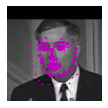

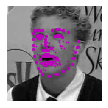

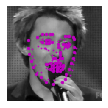

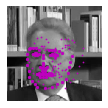

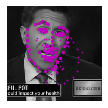

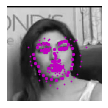

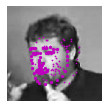

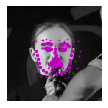

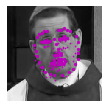

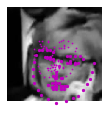

In [54]:
visualize_output(test_images,test_outputs,get_pts)

In [112]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

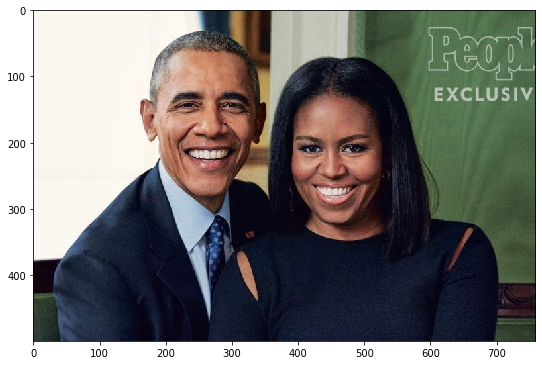

In [113]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg


image  = cv2.imread('images/obamas.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

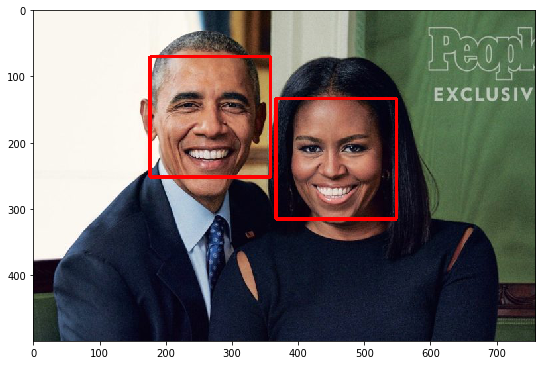

In [114]:
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, 1.5,1)
image_with_detections = image.copy()
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)
fig = plt.figure(figsize=(9,9))
plt.imshow(image_with_detections)

In [115]:
import torch
from models import Net
net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2,

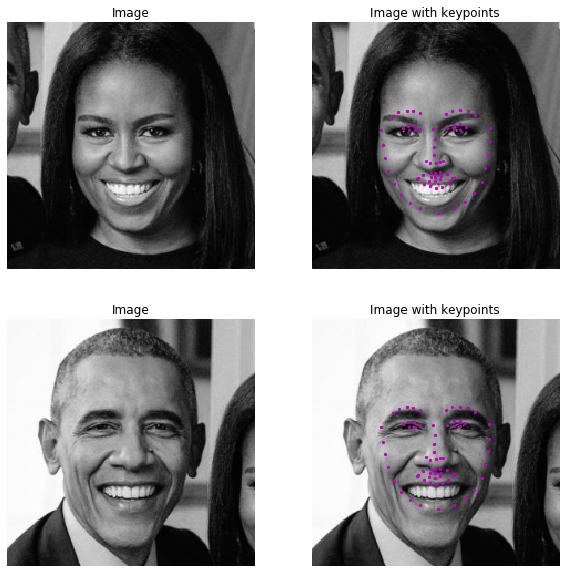

In [118]:

image_copy = np.copy(image)
results = []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray_copy = np.copy(gray)
    gray_copy =  gray_copy/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    output_size = 224
    h, w = gray_copy.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(gray_copy, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    img_reshaped = img.reshape(1, 1, new_w, new_h)
    input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)

    # forward pass to get net output
    output_pts = net(input_img)
    output_pts = output_pts.view(68, -1)
    output_pts = output_pts.detach().numpy()
    # undo normalization of keypoints  
    output_pts = output_pts*50.0+100
    
    results.append((img, output_pts))
    

    ## TODO: Display each detected face and the corresponding keypoints        
    
fig, axs = plt.subplots(len(results), 2, figsize=(10, 10))

for i in range(len(results)):

    im, key_pts = results[i]

    axs[i, 0].imshow(im, cmap = 'gray')
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(im, cmap = 'gray')
    axs[i, 1].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    axs[i, 1].set_title('Image with keypoints')
    axs[i, 1].axis('off')

plt.show()